https://m.blog.naver.com/daddy4885/223522241314

In [559]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# 설정
ETF_TICKERS = [
    # US Equities
    "VOO",  # S&P 500
    "QQQ",  # Nasdaq-100
    "DIA",  # Dow Jones Industrial Average
    "IWM",  # Russell 2000
    "EFA",  # MSCI EAFE (Developed Markets ex-US)
    "EEM",  # MSCI Emerging Markets
    
    # Major Non-US Stock Market Indices
    "EWJ",  # Japan (Nikkei 225)
    "FXI",  # China (FTSE China 50)
    "VGK",  # Europe (FTSE Developed Europe)
    "EWA",  # Australia (MSCI Australia)
    "EWZ",  # Brazil (MSCI Brazil)
    "INDA", # India (MSCI India)
    "EWC",  # Canada (MSCI Canada)
    "EWY",  # South Korea (MSCI South Korea)
    
    # Fixed Income (Bonds)
    "TLT",  # Long-term US Treasuries (20+ Year)
    "IEF",  # Medium-term US Treasuries (7-10 Year)
    "LQD",  # Investment Grade Corporate Bonds
    "HYG",  # High-Yield Corporate Bonds
    
    # Commodities
    "GLD",  # Gold
    "SLV",  # Silver
    "USO",  # Crude Oil
    "UNG",  # Natural Gas
    
    # Crypto ETFs
    "BITO",  # Bitcoin Futures ETF
    "IBIT",  # Spot Bitcoin ETF (BlackRock)
    "ETHE",  # Ethereum Trust (Grayscale)
    
    # Volatility ETFs
    "VXX",  # Short-Term VIX Futures
    "UVXY", # Leveraged VIX Futures
    
    # Real Estate (REITs)
    "VNQ",  # US REITs
    "IYR",  # US Real Estate
    
    # Currencies
    "UUP",  # US Dollar Bullish Index
    "FXE"   # Euro Currency ETF
]

DATA_AVAILABILITY_YEARS = 14
START_DATE = pd.Timestamp.now().floor('D') - pd.Timedelta(365*DATA_AVAILABILITY_YEARS, unit='d')
LOOKBACK_YEARS = 7  # 투자 기간
ANNUAL_RETURN_TARGET = 0.08
MDD_LIMIT = -(ANNUAL_RETURN_TARGET * 2) # not in annualized (constant-period) movement, but a periodic movement focusing on max drawdown

# 데이터 다운로드
def get_etf_data(tickers, start):
    data = yf.download(tickers, start=start)["Close"]
    return data#.dropna()

# ETF 생존 필터링 (시작일 이후 충분한 데이터가 있는 ETF만 유지)
def filter_etfs_by_data_availability(tickers, start):
    data = get_etf_data(tickers, start)
    valid_etfs = data[data.index > start].dropna(how='any', axis=1)
    return valid_etfs

data = filter_etfs_by_data_availability(ETF_TICKERS, START_DATE)
ETF_TICKERS = data.columns

# 3년 투자 수익률 및 통계 계산
def compute_Nyear_metrics(prices, LOOKBACK_YEARS):
    n_days = 252 * LOOKBACK_YEARS
    rolling_returns = prices.shift(-n_days) / prices - 1
    annualized_returns = (1 + rolling_returns) ** (1 / LOOKBACK_YEARS) - 1
    mean_returns = annualized_returns.mean()
    
    drawdowns = prices / prices.cummax() - 1
    rolling_mdds = drawdowns.rolling(n_days, min_periods=1).min()
    min_mdds = rolling_mdds.min()
    
    return rolling_returns, rolling_mdds, mean_returns, min_mdds

rolling_returns, rolling_mdds, etf_returns, etf_mdds = compute_Nyear_metrics(data, LOOKBACK_YEARS)

def compute_success_probabilities(prices, ANNUAL_RETURN_TARGET):
    n_days = 252 * LOOKBACK_YEARS
    rolling_returns = prices.shift(-n_days) / prices - 1
    annualized_returns = (1 + rolling_returns) ** (1 / LOOKBACK_YEARS) - 1
    success_probs = (annualized_returns >= ANNUAL_RETURN_TARGET).mean()
    return success_probs

success_probs = compute_success_probabilities(data, ANNUAL_RETURN_TARGET)

# 포트폴리오 최적화
def objective(weights):
    return -np.dot(weights, success_probs.values)  # 확률 최대화 (음수 사용)

def constraint_return(weights):
    return np.dot(weights, etf_returns.values) - ANNUAL_RETURN_TARGET

def constraint_mdd(weights):
    return MDD_LIMIT - np.dot(weights, etf_mdds.values)

def constraint_sum(weights):
    return np.sum(weights) - 1  # 전체 비중이 100%가 되도록 제한

constraints = [
    {'type': 'eq', 'fun': constraint_sum},   # 전체 합이 100%
    {'type': 'ineq', 'fun': constraint_return},  
    {'type': 'ineq', 'fun': constraint_mdd}
]

bounds = [(0, 1) for _ in ETF_TICKERS]
initial_weights = np.full(len(ETF_TICKERS), 1 / len(ETF_TICKERS))

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

# 최적 비중 출력
optimal_weights = result.x
weights_df = (
    pd.DataFrame({'ETF': ETF_TICKERS, 'Weight': optimal_weights})
    .sort_values(by='Weight', ascending=False)
    .reset_index().drop(columns='index')
)
weights_df = weights_df[weights_df['Weight'].round(4) > 0]
weights_df['Weight'] = weights_df['Weight'].map(lambda x: f"{x:.2%}")
display(weights_df)

[*********************100%***********************]  31 of 31 completed


,ETF,Weight
0,QQQ,55.58%
1,VOO,44.42%


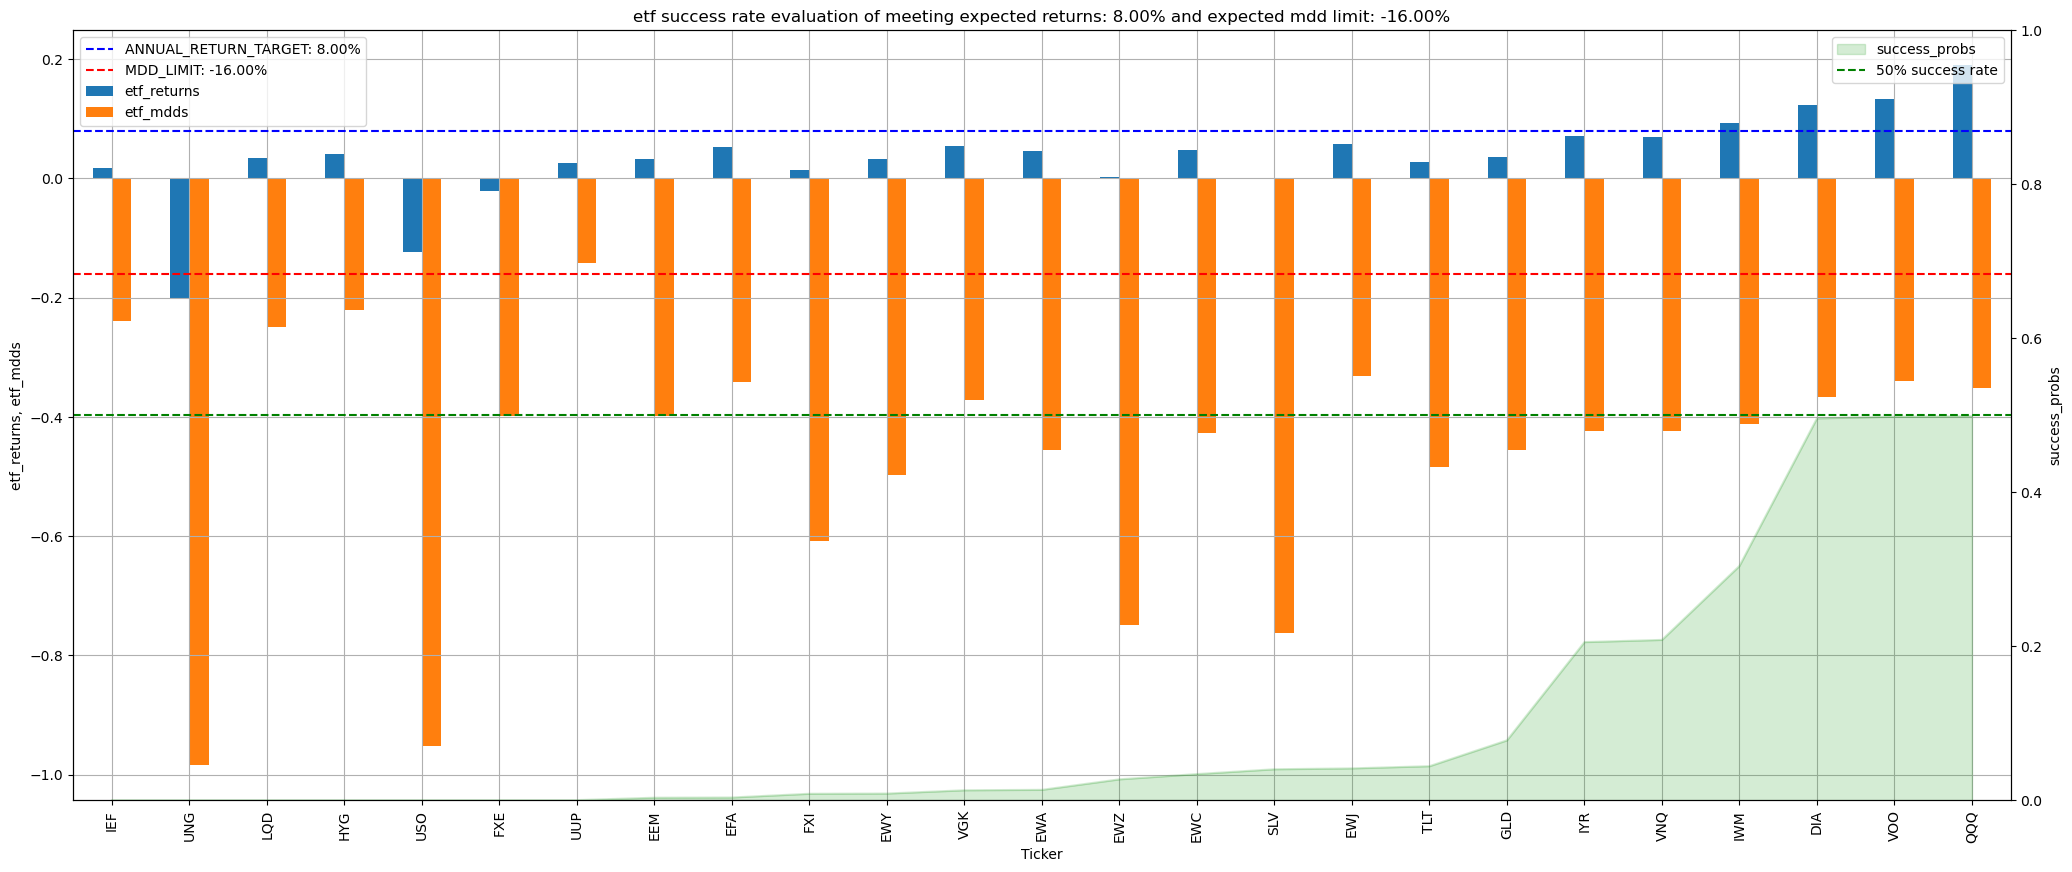

In [560]:
comb_analysis = pd.concat([etf_returns.rename('etf_returns'), etf_mdds.rename('etf_mdds'), success_probs.rename('success_probs')], axis=1)

fig,ax = plt.subplots(figsize=(25,10))
ax0 = ax.twinx()
comb_analysis.sort_values(by='success_probs').drop(columns='success_probs').plot(kind='bar', ax=ax)
comb_analysis.sort_values(by='success_probs').success_probs.plot(kind='area', ax=ax0, color='tab:green', label='success_probs', alpha=0.2)
ax.axhline(ANNUAL_RETURN_TARGET, label=f'ANNUAL_RETURN_TARGET: {ANNUAL_RETURN_TARGET :.2%}', c='blue', ls='--')
ax.axhline(MDD_LIMIT, label=f'MDD_LIMIT: {MDD_LIMIT :.2%}', c='red', ls='--')
ax0.axhline(0.5, label=f'50% success rate', c='green', ls='--')
ax.legend()
ax0.legend()
ax0.set_ylim(0,1)
ax0.set_ylabel('success_probs')
ax.set_ylabel('etf_returns, etf_mdds')
ax.set_title(f'etf success rate evaluation of meeting expected returns: {ANNUAL_RETURN_TARGET :.2%} and expected mdd limit: {MDD_LIMIT :.2%}')
ax.grid();

Ticker
DIA    0.129144
VOO    0.149507
QQQ    0.203143
dtype: float64

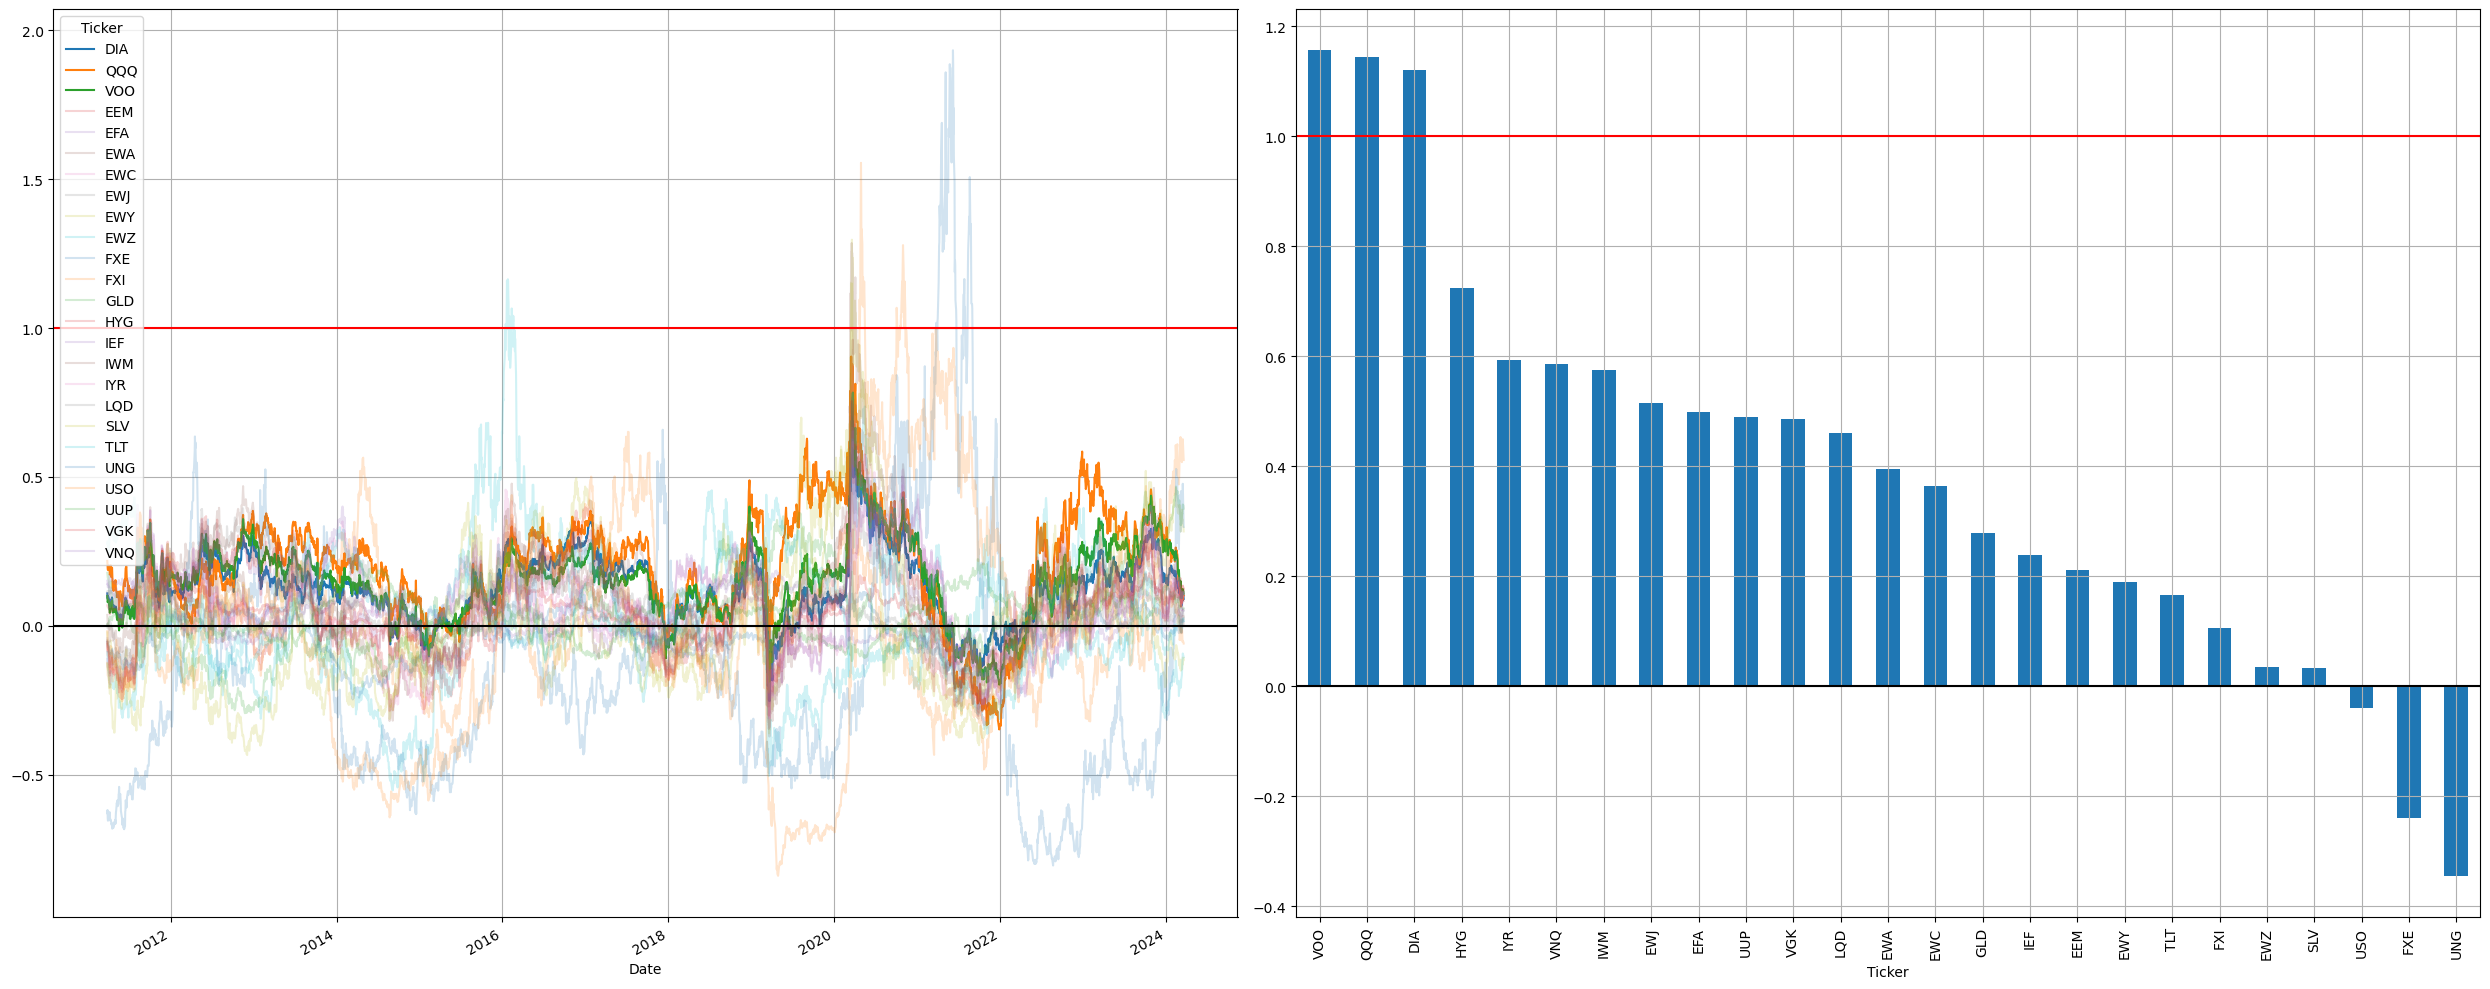

In [661]:
# rolling yearly holding period returns (HPR) (DCA sensitivity test)
rolling_returns, rolling_mdds, etf_returns, etf_mdds = compute_Nyear_metrics(data, LOOKBACK_YEARS=1)

fig,ax = plt.subplots(1,2, figsize=(25,10))
dca_sensitivity_SR = rolling_returns.mean() / rolling_returns.std()
best_etfs = dca_sensitivity_SR[dca_sensitivity_SR > 1].index.tolist()
rolling_returns[best_etfs].plot(ax=ax[0])
rolling_returns.drop(columns=best_etfs).plot(ax=ax[0], alpha=0.2)
dca_sensitivity_SR.sort_values(ascending=False).plot(kind='bar', ax=ax[1])

for i in range(len(ax)):
    ax[i].axhline(0, c='black')
    ax[i].axhline(1, c='red')
    ax[i].grid()
plt.tight_layout();

# rolling DCA HPR
rolling_returns[best_etfs].mean().sort_values()